<a href="https://colab.research.google.com/github/agarr3/BertLong/blob/master/WI_ONE_CHANNEL_CLASS_SCRATCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

#settings
batch_size = 128
validation_split = .3
shuffle_dataset = True
random_seed= 42

criterion = nn.CrossEntropyLoss()


n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/WI_CLASSIFIER/"

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# DATA_BASE_PATH = "/content/gdrive/My Drive/Kaggle/GTZAN/Data/"
# DATA_SONG_DIR = "genres_original"
# DATA_IMG_DIR = "images_original"

# image = []
# labels = []
# songs = []

# for r,d, fileList in os.walk(DATA_BASE_PATH + DATA_SONG_DIR):
#   for file in fileList:
#     pre, ext = os.path.splitext(file)
#     # print(pre)
#     # print(file)
#     dir = r.split("/")[-1]
#     labels.append(dir)
#     # image.append(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, r.split("/")[-1], pre.replace(".","")+".png"))
#     # songs.append(os.path.join(r,file))
#     image.append(pre.replace(".","")+".png")
#     songs.append(file)


# data = {'Images':image, "songs" :songs,'labels':labels} 
# data = pd.DataFrame(data) 
# data.head()

In [5]:
DATA_BASE_PATH = "/content/gdrive/"
DATA_SONG_DIR = "My Drive"
DATA_IMG_DIR = "My Drive"

files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/gdrive/My Drive/Western_numpy"):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
files = random.sample(files, 2008)

for r,d, fileList in os.walk("/content/gdrive/My Drive/Indian_numpy"):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_numpy"])
    else:
      print(file)

data = pd.DataFrame(files, columns=['Images','songs','labels'])
#data = data.sample(frac=1).reset_index(drop=True)

print(len(data.index))
data.head()

4016


,Images,songs,labels
0,029351.npy,029351.npy,Western_numpy
1,093716.npy,093716.npy,Western_numpy
2,143217.npy,143217.npy,Western_numpy
3,131912.npy,131912.npy,Western_numpy
4,147059.npy,147059.npy,Western_numpy


In [6]:
data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2008,2008
Western_numpy,2008,2008


In [ ]:
test_idx = random. randint(0,1000)
# test_song = os.path.join(DATA_BASE_PATH, DATA_SONG_DIR, labels[test_idx], songs[test_idx])
# print(test_song)
# ipd.Audio(test_song) # load a local WAV file


/content/gdrive/My Drive/Western_numpy/027855.npy
66.531906


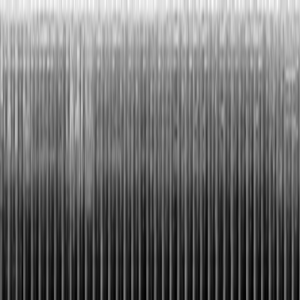

In [16]:
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, data.loc[test_idx, 'labels'], data.loc[test_idx, 'Images'])
print(test_img_path)
#ipd.Image(filename=test_img_path)
# test_image = Image.open(test_img_path)
# test_image = test_image.convert('RGB')
# test_image

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



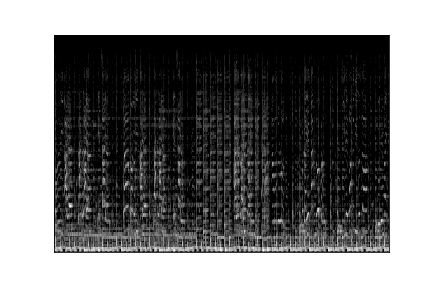

In [17]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [ ]:
print(labels[test_idx])

tensorTrans = transforms.ToTensor()
test_image = tensorTrans(test_image)
test_image.shape

In [19]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,songs,labels,encoded_labels
0,029351.npy,029351.npy,Western_numpy,1
1,093716.npy,093716.npy,Western_numpy,1
2,143217.npy,143217.npy,Western_numpy,1
3,131912.npy,131912.npy,Western_numpy,1
4,147059.npy,147059.npy,Western_numpy,1


In [20]:
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [21]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [22]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [23]:
class IMG_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image = image.convert('RGB').convert('L')
        #image = image.convert('RGB')
        #image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        #image = image.convert('RGB').convert('L')
        #image = image.convert('RGB')
        #image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label



In [24]:
dataset = MEL_Dataset(data,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)



In [25]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [26]:
data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2008,2008
Western_numpy,1,2008,2008


In [33]:
def img_display(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg.squeeze()

def mel_display(S_DB):
    print(S_DB.shape)
    S_DB = S_DB.numpy()
    array = S_DB*-1
    print(array.max())
    array *= (255.0/array.max())
    array = 255 - array

    array = np.transpose(array, (1, 2, 0))
    return array.squeeze()

torch.Size([1, 26, 400])
67.537994
torch.Size([1, 26, 400])
58.63179
torch.Size([1, 26, 400])
80.0
torch.Size([1, 26, 400])
52.46012
torch.Size([1, 26, 400])
69.964005
torch.Size([1, 26, 400])
69.07929
torch.Size([1, 26, 400])
59.41851
torch.Size([1, 26, 400])
60.44189
torch.Size([1, 26, 400])
76.99865
torch.Size([1, 26, 400])
65.05542
torch.Size([1, 26, 400])
54.35418
torch.Size([1, 26, 400])
66.62348
torch.Size([1, 26, 400])
65.39432
torch.Size([1, 26, 400])
67.34591
torch.Size([1, 26, 400])
40.737846


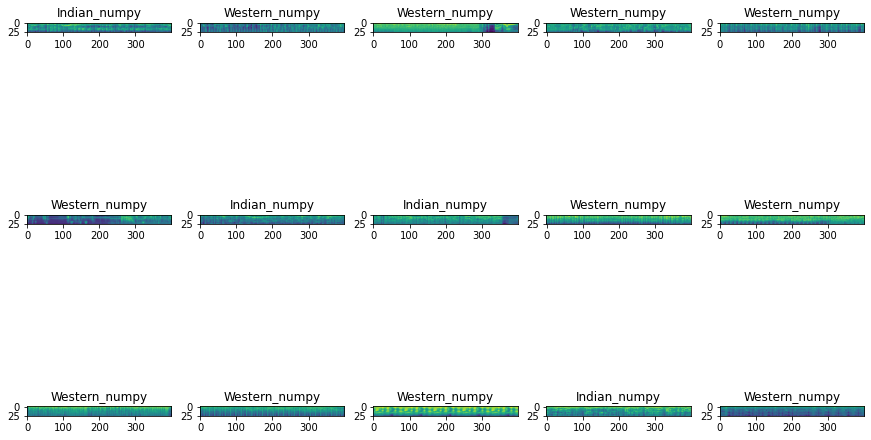

In [34]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [35]:
class SimpleCNNModel(nn.Module):
    def __init__(self):
        super(SimpleCNNModel, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        #self.fc1 = nn.Linear(64*5*5,512 )
        self.fc1 = nn.Linear(64*5*7,512 )
        
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        #x = x.view(-1, 64*5*5) # Flatten layer
        x = x.view(-1, 64*5*7) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [40]:
class SimpleCNNModelOneChannel(nn.Module):
    def __init__(self):
        super(SimpleCNNModelOneChannel, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        #self.fc1 = nn.Linear(64*5*5,512 )
        self.fc1 = nn.Linear(384,512 )
        
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        #x = x.view(-1, 64*5*5) # Flatten layer
        x = x.view(-1, 384) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [41]:
#model = SimpleCNNModel() # On CPU
#model = SimpleCNNModel().to(device)  # On GPU
model = SimpleCNNModelOneChannel().to(device)  # On GPU
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

SimpleCNNModelOneChannel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [38]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [ ]:
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\nepoch: {epoch}, train loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), os.path.join(BASE_PATH, 'model_classification_tutorial.pt'))
            print('Detected network improvement, saving current model')
        
        fig = plt.figure(figsize=(20,10))
        plt.title("Train - Validation Loss")
        plt.plot( train_loss, label='train')
        plt.plot( val_loss, label='validation')
        plt.xlabel('num_epochs', fontsize=12)
        plt.ylabel('loss', fontsize=12)
        plt.legend(loc='best')
        plt.savefig(os.path.join(BASE_PATH, 'loss_plot.png'), bbox_inches='tight')

        fig = plt.figure(figsize=(20,10))
        plt.title("Train - Validation Accuracy")
        plt.plot(train_acc, label='train')
        plt.plot(val_acc, label='validation')
        plt.xlabel('num_epochs', fontsize=12)
        plt.ylabel('accuracy', fontsize=12)
        plt.legend(loc='best')
        plt.savefig(os.path.join(BASE_PATH, 'accuracy_plot.png'), bbox_inches='tight')

    model.train()

In [ ]:
model.load_state_dict(torch.load(os.path.join(BASE_PATH, 'model_classification_tutorial.pt')))

In [ ]:
images, labels = dataiter.next()
arthopod_types = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(arthopod_types[label.item()])+":" +str(k)) # add label